In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
typo_df = pd.read_pickle('typo_df.pkl')
print(typo_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9974 entries, 0 to 9973
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   typo                     9974 non-null   object
 1   flag                     9974 non-null   object
 2   command                  9974 non-null   object
 3   encoded_typo             9974 non-null   object
 4   encoded_flag             9974 non-null   int64 
 5   encoded_command          9974 non-null   int64 
 6   encoded_input            9974 non-null   object
 7   one_hot_encoded_command  9974 non-null   object
dtypes: int64(2), object(6)
memory usage: 623.5+ KB
None


In [3]:
print("INPUT LENGTH: "+str(len(typo_df['encoded_input'][0])))
print("OUTPUT LENGTH: "+str(len(typo_df['one_hot_encoded_command'][0])))

INPUT LENGTH: 31
OUTPUT LENGTH: 74


In [4]:
def split_data(x, y, test_size):
    x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=test_size)
    return torch.tensor(x_train), torch.tensor(x_validation), torch.tensor(y_train), torch.tensor(y_validation)

y = np.array(typo_df["one_hot_encoded_command"].values.tolist(), dtype=np.float32)
x = np.array(typo_df["encoded_input"].values.tolist(), dtype=np.float32)
x_train, x_validation, y_train, y_validation = split_data(x, y, .2)

train_dataset = data_utils.TensorDataset(x_train, y_train) 
val_dataset = data_utils.TensorDataset(x_validation, y_validation)
#holdout_dataset = data_utils.TensorDataset(x_holdout, y_holdout) 

batch_size = 16
train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
val_loader = data_utils.DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle = True)
#holdout_loader = data_utils.DataLoader(dataset = holdout_dataset, batch_size = batch_size, shuffle = True)

In [5]:
# Define your network architecture here
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(len(typo_df['encoded_input'][0]), 215)
        self.fc2 = nn.Linear(215, 125)
        self.fc3 = nn.Linear(125, len(typo_df['one_hot_encoded_command'][0]))
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        
        return x

# Create the custom network above, define the loss criterion, and choose an optimizer to learn weights
model = Classifier()
loss_criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.3)

In [6]:
def get_accuracy(outputs, labels):
    num_correct = 0
    predictions = torch.argmax(outputs, 1)
    true_values = torch.argmax(labels, 1)
    for i in range(len(predictions)):
        if predictions[i] == true_values[i]:
            num_correct +=1
    return(num_correct/len(predictions))

In [7]:
# Create lists to hold training and val loss values
train_losses = []
val_losses = []

# Create lists to hold training and val accuracy values
train_accuracies = []
val_accuracies = []

# Train the network here
epochs = 75

for e in range(epochs):
    print("In epoch", e)
    running_loss = 0
    running_accuracies = []
    for inputs, labels in train_loader: # processing one batch at a time
        outputs = model(inputs) # predict labels
        loss = loss_criterion(outputs, labels) # calculate the loss
        
        # BACK PROPAGATION OF LOSS to generate updated weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_accuracies.append(get_accuracy(outputs, labels))
        
    running_val_loss = 0    
    running_val_accuracies = []
    for val_inputs, val_labels in val_loader:
        val_outputs = model(val_inputs)
        running_val_accuracies.append(get_accuracy(val_outputs, val_labels))
        val_loss = loss_criterion(val_outputs, val_labels)
        running_val_loss += val_loss.item()
        
    print(f"\tTraining accuracy: {sum(running_accuracies)/len(running_accuracies)}")
    print(f"\tValidation accuracy: {sum(running_val_accuracies)/len(running_val_accuracies)}")
    print('')
    print(f"\tTraining loss: {running_loss/len(train_loader)}")
    print(f"\tValidation loss: {running_val_loss/len(val_loader)}")
    
    train_accuracies.append(sum(running_accuracies)/len(running_accuracies))
    val_accuracies.append(sum(running_val_accuracies)/len(running_val_accuracies))
    
    train_losses.append(running_loss/len(train_loader))
    val_losses.append(running_val_loss/len(val_loader))

In epoch 0
	Training accuracy: 0.32986427400255053
	Validation accuracy: 0.5160909090909092

	Training loss: 0.0102753085886802
	Validation loss: 0.008363345060497523
In epoch 1
	Training accuracy: 0.48914875204955366
	Validation accuracy: 0.5285909090909091

	Training loss: 0.00818679547137982
	Validation loss: 0.007567160041071474
In epoch 2
	Training accuracy: 0.5461149571871015
	Validation accuracy: 0.5830909090909091

	Training loss: 0.007457212818868623
	Validation loss: 0.00696795797906816
In epoch 3
	Training accuracy: 0.5766191473856804
	Validation accuracy: 0.6016363636363636

	Training loss: 0.0069067216663059585
	Validation loss: 0.00647148771956563
In epoch 4
	Training accuracy: 0.6479322280925487
	Validation accuracy: 0.6940909090909091

	Training loss: 0.005772769566856788
	Validation loss: 0.005037692748941481
In epoch 5
	Training accuracy: 0.6892648934232101
	Validation accuracy: 0.6735454545454546

	Training loss: 0.005063746202543923
	Validation loss: 0.0050644678631

	Training accuracy: 0.8718687374749499
	Validation accuracy: 0.8785454545454545

	Training loss: 0.002144069791732861
	Validation loss: 0.0021603330484358594
In epoch 50
	Training accuracy: 0.8705593004190199
	Validation accuracy: 0.8793181818181819

	Training loss: 0.0021632272979889627
	Validation loss: 0.002092340913251974
In epoch 51
	Training accuracy: 0.873383129896156
	Validation accuracy: 0.8765

	Training loss: 0.0021419999357586896
	Validation loss: 0.002124671588827823
In epoch 52
	Training accuracy: 0.873257879395154
	Validation accuracy: 0.8825

	Training loss: 0.0021292467154891423
	Validation loss: 0.002036237758489733
In epoch 53
	Training accuracy: 0.8730073783931499
	Validation accuracy: 0.8772727272727272

	Training loss: 0.002121637011102625
	Validation loss: 0.0020769614565651863
In epoch 54
	Training accuracy: 0.873326197850246
	Validation accuracy: 0.8763181818181819

	Training loss: 0.0021166917058453583
	Validation loss: 0.0020435117111192087
In epoch 55
	Train

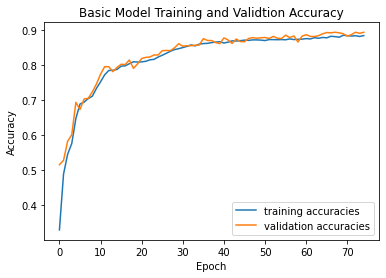

In [8]:
plt.figure(1)
line1, = plt.plot(train_accuracies)
line1.set_label('training accuracies')
line2, = plt.plot(val_accuracies)
line2.set_label('validation accuracies')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Basic Model Training and Validtion Accuracy')
plt.savefig('accuracy.png', format='png')
plt.show()

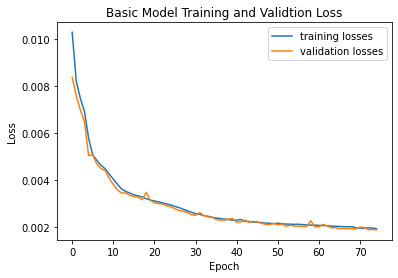

In [9]:
plt.figure(2)
line1, = plt.plot(train_losses)
line1.set_label('training losses')
line2, = plt.plot(val_losses)
line2.set_label('validation losses')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Basic Model Training and Validtion Loss')
plt.savefig('loss.png', format='png')
plt.show()